In [359]:
#https://codesachin.wordpress.com/2015/11/28/self-organizing-maps-with-googles-tensorflow/

%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

import random as ran
from tensorflow.examples.tutorials.mnist import input_data
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix as get_confusion_matrix

In [360]:
class SOM(object):

    # To check if the SOM has been trained
    trained = False

    def __init__(self, dim_x_som, dim_y_som, dim_img, n_iterations=100, alpha=0.2, sigma=None):
        """
        dim_x_som (int) dimensão x do SOM
        dim_y_som (int) dimensão y do SOM  
        dim_img (array, (2x2))(float) shape of each instance data
        n_iterations (int) número de iterações
        alpha (float)
        sigma (float) (default =max(m, n)/2.)
        """
        self.dim_x_som = dim_x_som
        self.dim_y_som = dim_y_som
      
            
        if sigma is None:
            sigma = max(dim_x_som, dim_y_som) / 2.0
        else:
            sigma = float(sigma)
        self.n_iterations = n_iterations

        self.graph = tf.Graph()

        with self.graph.as_default():

            # To save data, create weight vectors and their location vectors
            # cada nodo dos m*n vertíces se associa com a dimensão da imagem 
            #(não é 2d, mas o número de pixels da imagem)
            # exitem m*n neurônios
            self.weightage_vects = tf.Variable(
                tf.random_normal( 
                    [dim_x_som*dim_y_som, dim_img]
                )
            )

            self.location_vects = tf.constant(np.array(list(self.neuron_locations())))

            # Training inputs

            #  o vetor de entrada tem dimensão da imagem
            self.vect_input = tf.placeholder("float", [dim_img])
            
            # Iteration number
            self.iter_input = tf.placeholder("float")

            # Training Operation  # tf.pack result will be [ (m*n),  dim ]
            # reduce
            # tf.argmin retorna o indice com menor valor ao longo do eixo x
            # tf.reduce_sum realiza a soma de todos os valores ao longo do eixo y
            bmu_index = tf.argmin(
                tf.sqrt(
                    tf.reduce_sum(
                        tf.pow(
                            tf.subtract(
                                tf.stack(
                                    [
                                        self.vect_input for _ in range(dim_x_som*dim_y_som)
                                    ]
                                ),
                                self.weightage_vects
                            ),
                            2
                        ),
                        1
                    )
                ),
                0
            ) 
                    

            slice_input = tf.pad(
                tf.reshape(bmu_index, [1]), 
                np.array([[0, 1]])
            )
            bmu_loc = tf.reshape(
                tf.slice(
                    self.location_vects, 
                    slice_input, 
                    tf.constant(np.array([1, 2]))
                ), 
                [2]
            )

            # To compute the alpha and sigma values based on iteration number
            learning_rate_op = tf.subtract(
                1.0, 
                tf.div(
                    self.iter_input, 
                    self.n_iterations
                )
            )
            alpha_op = tf.multiply(alpha, learning_rate_op)
            sigma_op = tf.multiply(sigma, learning_rate_op)

            # learning rates for all neurons, based on iteration number and location w.r.t. BMU.
            bmu_distance_squares = tf.reduce_sum(
                tf.pow(
                    tf.subtract(
                        self.location_vects, 
                        tf.stack( 
                            [
                                bmu_loc 
                                for _ in range(dim_x_som*dim_y_som)
                            ] 
                        ) 
                    ),
                    2 
                ), 
                1
            )

            neighbourhood_func = tf.exp(
                tf.negative(
                    tf.div(
                        tf.cast(
                            bmu_distance_squares, 
                            "float32"
                        ), 
                        tf.pow(sigma_op, 2)
                    )
                )
            )
            learning_rate_op = tf.multiply(alpha_op, neighbourhood_func)

            # Finally, the op that will use learning_rate_op to update the weightage vectors of all neurons
            learning_rate_multiplier = tf.stack(
                [
                    tf.tile(
                        tf.slice(
                            learning_rate_op, 
                            np.array([i]),
                            np.array([1])
                        ), 
                        [dim_img]
                    ) 
                    for i in range(dim_x_som*dim_y_som)
                ]
            )

            ### Strucutre of updating weight ###
            ### W(t+1) = W(t) + W_delta ###
            ### wherer, W_delta = L(t) * ( V(t)-W(t) ) ###

            # W_delta = L(t) * ( V(t)-W(t) )
            weightage_delta = tf.multiply(
                learning_rate_multiplier,
                tf.subtract(
                    tf.stack(
                        [
                            self.vect_input 
                            for _ in range(dim_x_som*dim_y_som)
                        ]
                    ), 
                    self.weightage_vects
                )
            )

            # W(t+1) = W(t) + W_delta
            new_weightages_op = tf.add(self.weightage_vects, weightage_delta)

            # Update weightge_vects by assigning new_weightages_op to it.
            self.training_op = tf.assign(self.weightage_vects, new_weightages_op)

            self.sess = tf.Session()
            init_op = tf.global_variables_initializer()
            self.sess.run(init_op)

    def neuron_locations(self):

        for i in range(self.dim_x_som):
            for j in range(self.dim_y_som):
                yield np.array([i, j])

    def train(self, input_vects):

        # Training iterations
        for iter_number in range(self.n_iterations):
            # Train with each vector one by one
            for input_vect in input_vects:
                self.sess.run(
                    self.training_op, 
                    feed_dict={
                        self.vect_input: input_vect, 
                        self.iter_input: iter_number
                    }
            )

        # Store a centroid grid for easy retrieval later on
        centroid_grid = [
            [] 
            for i in range(self.dim_x_som)
        ]
        self.weightages = list(self.sess.run(self.weightage_vects))
        self.locations = list(self.sess.run(self.location_vects))
        for i, loc in enumerate(self.locations):
            centroid_grid[loc[0]].append(self.weightages[i])

        self.centroid_grid = centroid_grid

        self.trained = True

    def get_centroids(self):

        if not self.trained:
            raise ValueError("SOM not trained yet")
        return self.centroid_grid

    def map_vects(self, input_vects):

        if not self.trained:
            raise ValueError("SOM not trained yet")

        to_return = []
        for vect in input_vects:
            min_index = min(
                    [
                        i 
                        for i in range(len(self.weightages))
                    ], 
                    key=lambda x: np.linalg.norm(vect - self.weightages[x]) 
            )
            to_return.append(self.locations[min_index])

        return to_return

## Extrator de dados

100 imagens, cada imagem tem dimensão 28x28

o one_hot significa one hot econding

5 = 0000010000

2 = 0010000000

In [352]:
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)

def train_size(num, digits=None):
    if digits is None:
        x_train = mnist.train.images[:num,:]
        y_train = mnist.train.labels[:num,:]
    else:
        y_train = []
        x_train = []
        for x, y in zip(mnist.train.images, mnist.train.labels):
            if any([y[digit]==1. for digit in digits]):
                x_train.append(x)
                y_train.append(y)
       

            
        x_train = np.array(x_train)[:num,:]
        y_train = np.array(y_train)[:num,:]

    return x_train, y_train

digits=range(5)
x_train, y_train = train_size(100, digits=digits)
x_test, y_test = train_size(200, digits=digits)
x_test = x_test[100:200,:]; y_test = y_test[100:200,:]



Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Trainamento

Cria um SOM de tamanho (dim_x, dim_y) e realiza n_iterations iterações

In [345]:
dim_x = 30
dim_y = 30
shape_img = (28, 28)
n_iterations = 500
dim_img = x_train.shape[1]
som = SOM(
    dim_x, 
    dim_y, 
    dim_img, 
    n_iterations=n_iterations
)
som.train(x_train)


## Extrai os pesos por neurônio e plota os valores

In [346]:
full_plot_by_neuron = [
    np.rot90(np.reshape(w, shape_img), k =3)
    for w in som.weightages
]


full_plot = [
    [
        np.zeros(shape_img)
        for j in range(dim_y)
    ]
    for i in range(dim_x)
]

for i, plot in enumerate(full_plot_by_neuron):
    #line = i//dim_x
    #col = i%dim_y
    line, col = som.locations[i]
    full_plot[line][col] = plot
full_plot = np.block(full_plot)

In [347]:
xs = range(full_plot.shape[0])
ys = range(full_plot.shape[1])
X_weights, Y_weights = np.meshgrid(xs, ys)

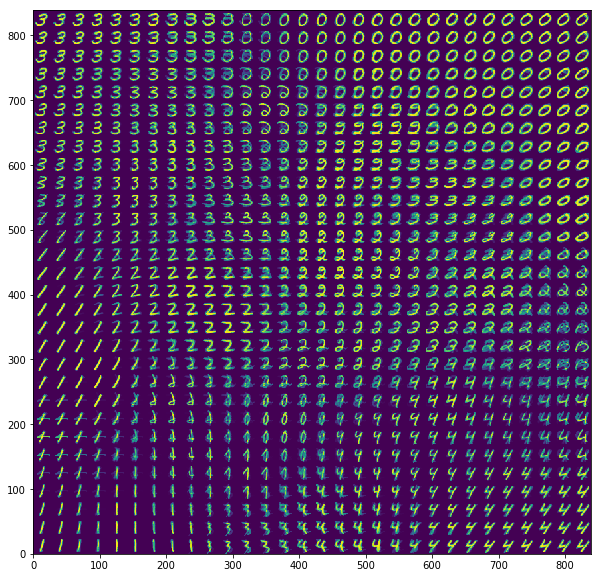

In [348]:


plt.figure(figsize=(10, 10))
plt.pcolormesh(X_weights, Y_weights, full_plot.T)
plt.show()

In [349]:


mapped = som.map_vects(x_train)

index_list = [ np.where(r==1)[0][0] for r in y_train ]
density_matrices = [
    np.zeros((dim_x, dim_y)) for digit in digits
]
for i, digit in enumerate(digits):
    ids_by_number, vals = zip(*filter(lambda val: val[1] == digit, enumerate(index_list)))
    mapped_by_digit = [mapped[id] for id in ids_by_number]
    z = len(mapped_by_digit)
    for x, y in mapped_by_digit:
        density_matrices[i][x, y] +=1/z*100




In [356]:
x_train_knn = som.map_vects(x_train)

y_train_knn = [ np.where(r==1)[0][0] for r in y_train ]
x_test_knn = som.map_vects(x_test)
y_test_knn = [ np.where(r==1)[0][0] for r in y_test ]




KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [361]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(x_train_knn,y_train_knn) 
y_pred_knn = neigh.predict(x_test_knn)
confusion = get_confusion_matrix(y_test_knn, y_pred_knn)

In [366]:

matching = np.zeros_like(confusion ,dtype=np.float32)
for i, line in enumerate(confusion):
    z = np.sum(line)
    for j, col in enumerate(line):
        matching[i,j ] = float(col)/float(z)*100

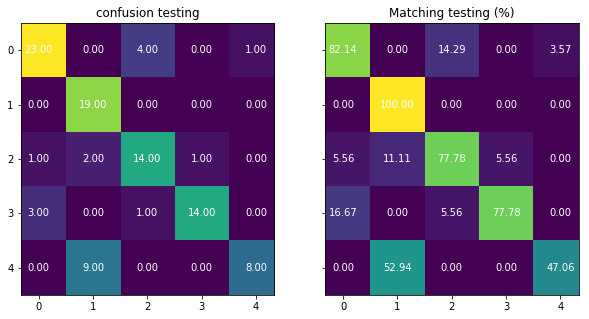

In [371]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(10, 5))

for title, data, ax in (
    ("confusion testing", confusion, axes[0]),
    ("Matching testing (%)", matching, axes[1])
):
    ax.set_title(title)
    ax.imshow(data)

    for x in range(len(digits)):
        for y in range(len(digits)):
            ax.annotate("{:.2f}".format(data[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        color="white",
                        verticalalignment='center')

    
    ax.set_xticks(range(len(digits)))
    ax.set_xticklabels(digits)
    ax.set_yticks(range(len(digits)))
    ax.set_yticklabels(digits)

plt.show()

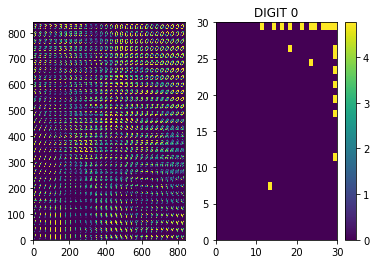

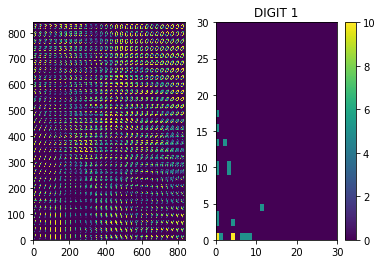

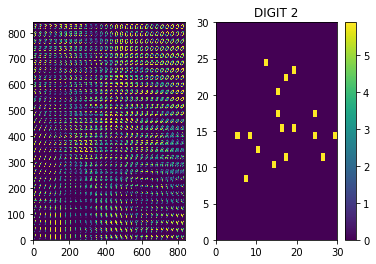

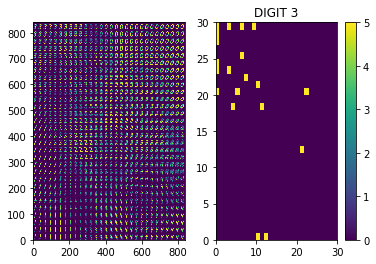

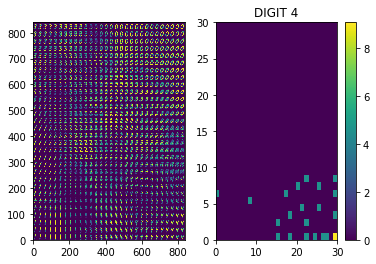

In [350]:
xs = range(dim_x)
ys = range(dim_y)
X, Y = np.meshgrid(xs, ys)
for i, digit in enumerate(digits):
    fig, axes = plt.subplots(1, 2)
    plt.title("DIGIT " + str(digit))
    cax = axes[1].pcolormesh(density_matrices[i].T)
    axes[0].pcolormesh(full_plot.T)

# Add colorbar, make sure to specify tick locations to match desired ticklabels
    cbar = fig.colorbar(cax)


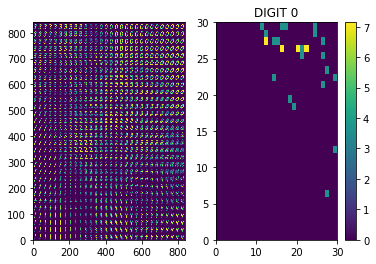

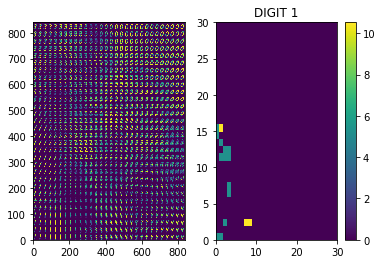

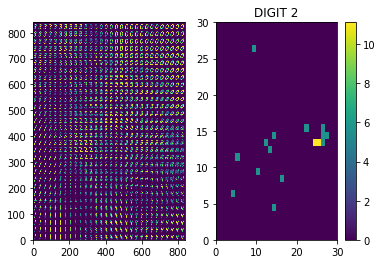

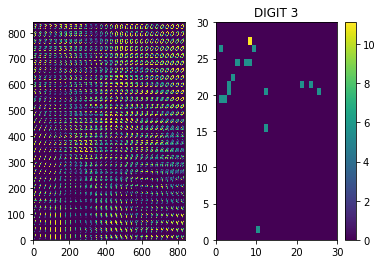

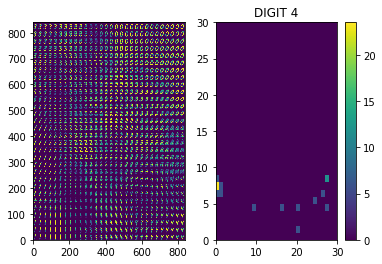

In [353]:


mapped = som.map_vects(x_test)

index_list = [ np.where(r==1)[0][0] for r in y_test ]
density_matrices = [
    np.zeros((dim_x, dim_y)) for digit in digits
]
for i, digit in enumerate(digits):
    ids_by_number, vals = zip(*filter(lambda val: val[1] == digit, enumerate(index_list)))
    mapped_by_digit = [mapped[id] for id in ids_by_number]
    z = len(mapped_by_digit)
    for x, y in mapped_by_digit:
        density_matrices[i][x, y] +=1/z*100

xs = range(dim_x)
ys = range(dim_y)
X, Y = np.meshgrid(xs, ys)

for i, digit in enumerate(digits):
    fig, axes = plt.subplots(1, 2)
    plt.title("DIGIT " + str(digit))
    cax = axes[1].pcolormesh(density_matrices[i].T)
    axes[0].pcolormesh(full_plot.T)

# Add colorbar, make sure to specify tick locations to match desired ticklabels
    cbar = fig.colorbar(cax)